In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import binom
import pandas as pd
import math
import pickle
import statsmodels.stats.power
import statsmodels.api as sm
import statsmodels.stats.multitest as mt
from sklearn import datasets

## Power

In [3]:
mu_0 = 30
mu_a = 32
alpha = 0.05
sigma = 4
n = 16
z = stats.norm.ppf(1 - alpha)
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_0, scale=sigma/np.sqrt(n)))
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n)))

0.049999999999999954
0.6387600313123348


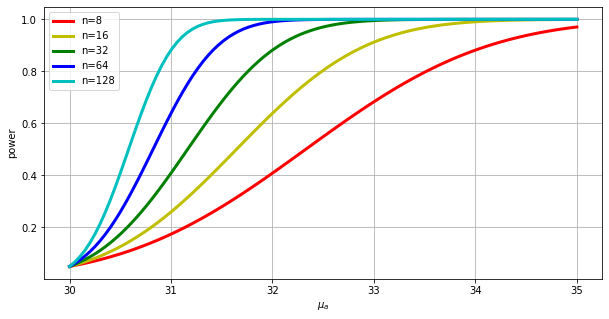

In [4]:
def power(mu_a, n):
    mu_0, alpha, sigma = 30, 0.05, 4
    z = stats.norm.ppf(1 - alpha)
    return stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n))

mu_a = np.linspace(30, 35, 100)

plt.figure(figsize=(10,5))
[plt.plot(mu_a, power(mu_a, n), lw=3, color=c) 
     for n,c in [(8, 'r'), (16, 'y'), (32, 'g'), (64, 'b'), (128, 'c')]
]
plt.grid()
plt.legend(['n=8', 'n=16', 'n=32', 'n=64', 'n=128'])
plt.xlabel('$\mu_a$')
plt.ylabel('power')
plt.show()

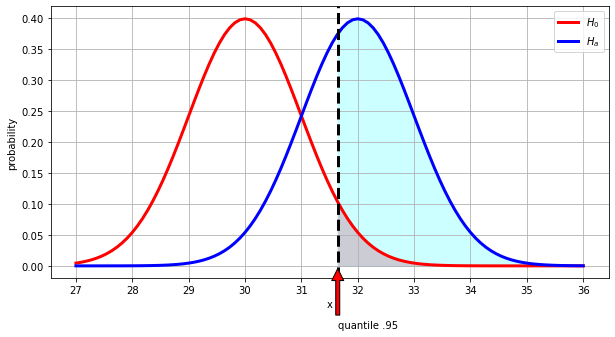

In [5]:
mu_0 = 30
mu_a = 32
sigma = 4
n = 16
alpha = 0.05

x = np.linspace(27, 36, 100)
y_0 = stats.norm.pdf(x, loc=mu_0, scale=sigma/np.sqrt(n))
y_a = stats.norm.pdf(x, loc=mu_a, scale=sigma/np.sqrt(n))
x_black = stats.norm.ppf(0.95, loc=mu_0, scale=sigma/np.sqrt(n))
x1 = np.linspace(x_black, 36, 100)

plt.figure(figsize=(10,5))
plt.plot(x, y_0, lw=3, c='r')
plt.plot(x, y_a, lw=3, c='b')
plt.legend(['$H_0$', '$H_a$'])
plt.grid()
plt.xticks(np.linspace(27, 36, 10))
plt.xlabel('x')
plt.ylabel('probability')
plt.axvline(x=x_black, c='k', linestyle='--', lw=3)
plt.annotate('quantile .95', 
            xy=(x_black, 0), 
            xytext=(x_black, -.1), 
            arrowprops = dict(facecolor='red', shrink=0.05))
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_0, scale=sigma/np.sqrt(n)), color="pink")
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_a, scale=sigma/np.sqrt(n)), color="cyan", alpha=0.2)
plt.show()

In [6]:
print(stats.norm.sf(x_black, loc=mu_a, scale=sigma/np.sqrt(n)))
print(statsmodels.stats.power.normal_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger')
)

0.6387600313123348
0.638760031312335


In [7]:
print('mu_0: %d, mu_a: %d' % (mu_0, mu_a))
print('sigma: ', sigma)
print('power: ', statsmodels.stats.power.ttest_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger'))

mu_0: 30, mu_a: 32
sigma:  4
power:  0.6040328683316007


In [8]:
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, nobs=16, alternative='larger'))
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, power=0.6040328, alternative='larger'))

0.6040328683316007
15.999997299353062


# Multiple tests

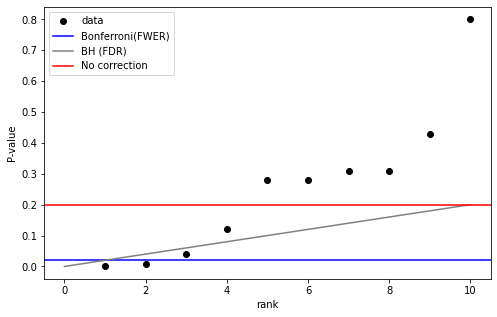

In [9]:
rank = np.array(range(10)) + 1
pValue = np.array([0.001, 0.007, 0.04, 0.12, 0.28, 0.28, 0.31, 0.31, 0.43, 0.8])
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(rank, pValue, 'o', c='k')
ax.axhline(y=0.02, c='b')
ax.plot([0, 10], [0., .2], c='gray')
ax.axhline(y=0.2, c='r')
ax.set_xlabel('rank')
ax.set_ylabel('P-value')
ax.legend(['data', 'Bonferroni(FWER)', 'BH (FDR)', 'No correction'])
plt.show()

In [10]:
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction: ', np.sum(pValues < 0.05))

no correction:  48


In [11]:
res = mt.multipletests(pValues, method='bonferroni')
print('Bonferroni correction: ', np.sum(res[1] < 0.05))

res = mt.multipletests(pValues, method='fdr_bh')
print('Benjamini/Hochberg correction: ', np.sum(res[1] < 0.05))

Bonferroni correction:  0
Benjamini/Hochberg correction:  0


In [12]:
# exemplu pentru care coeficientul w al regresiei liniare este:
# 0 pentru primele 500 de situatii construite
# 2 pentru urmatoarele
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20) if i < n//2 else (np.random.randn(20) + 2*x)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction:', np.sum(pValues < 0.05))
res = mt.multipletests(pValues, method='bonferroni')
print('corectie FWER:' , np.sum(res[1] < 0.05))

no correction: 529
corectie FWER: 473


In [13]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValue': pValues
})
pd.crosstab(df.pValue < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValue,,
False,0,471
True,500,29


In [14]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='bonferroni')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,27,500
True,473,0


In [15]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='fdr_bh')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,0,484
True,500,16


In [16]:
adjustBonf = mt.multipletests(pValues, method='bonferroni')[1]
adjustBH = mt.multipletests(pValues, method='fdr_bh')[1]

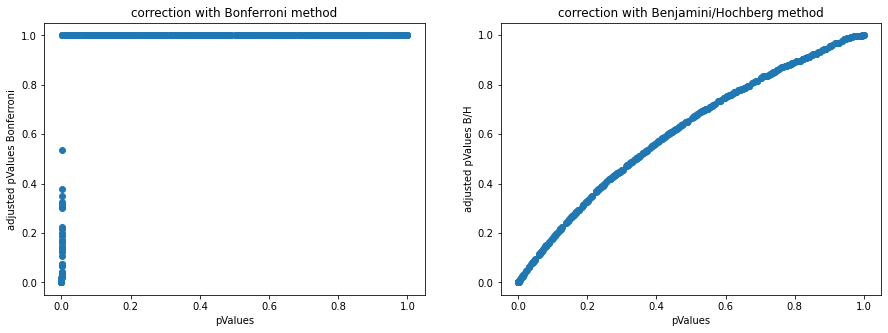

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))
ax1.plot(pValues, adjustBonf, 'o')
ax1.set_xlabel('pValues')
ax1.set_ylabel('adjusted pValues Bonferroni')
ax1.set_title('correction with Bonferroni method')
ax2.plot(pValues, adjustBH, 'o')
ax2.set_xlabel('pValues')
ax2.set_ylabel('adjusted pValues B/H')
ax2.set_title('correction with Benjamini/Hochberg method')
plt.show()

## Bootstrap

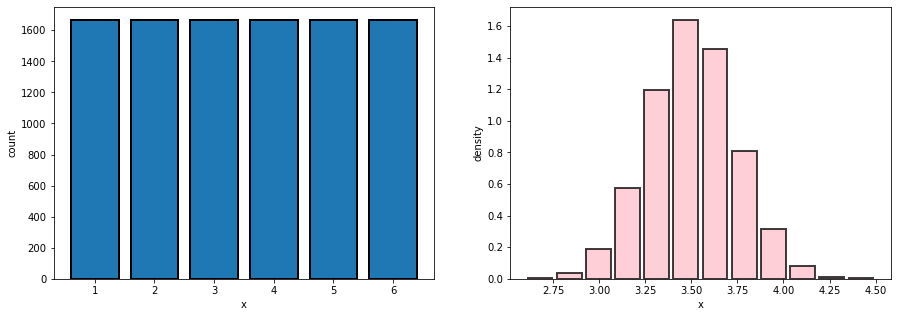

In [18]:
from functools import reduce

def roll(n):
    nosim = 10000
    x = np.random.randint(low=1, high=7, size=(nosim, n))
    return np.mean(x, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

ax1.bar(range(1, 7), [10000/6] * 6, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(50), bins=12, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

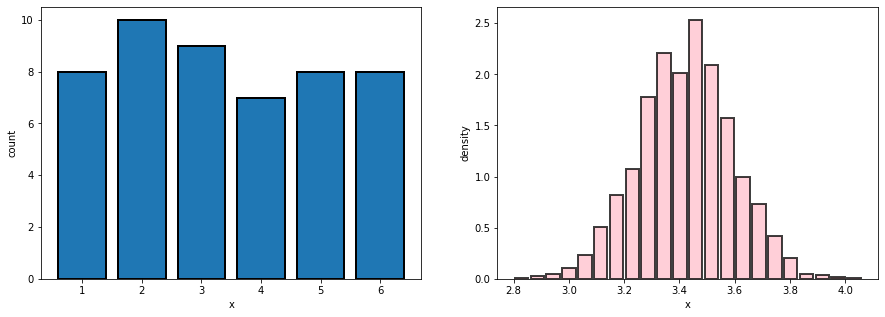

In [19]:
x = np.random.randint(low=1, high=7, size=(50))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

def roll(x, n):
    nosim = 10000
    x = np.random.choice(x, size=(nosim, n))
    return np.mean(x, axis=1)

l = [sum(np.array(x) == i) for i in range(1, 7)]

ax1.bar(range(1, 7), l, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(x, 100), bins=22, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

In [20]:
father_son = pd.read_csv('father_son.csv')
father_son.head()

,Unnamed: 0,fheight,sheight
0,1,65.04851,59.77827
1,2,63.25094,63.21404
2,3,64.95532,63.34242
3,4,65.75250,62.79238
4,5,61.13723,64.28113


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


deviatia standard:  0.10381955409072877
quantila 2.5%: 67.552325
quantila 97.5%: 67.94335


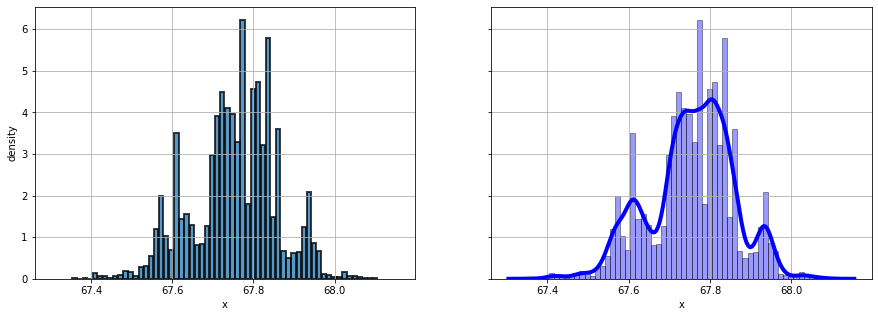

In [21]:
import seaborn

# vezi https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

x = father_son.fheight.values
n, nosims = len(x), 10000
resamples = np.random.choice(x, size=(nosims, n), replace=True)
resampledMedians = np.median(resamples, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)
ax1.hist(resampledMedians, **kwargs, bins=60)
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('density')
seaborn.distplot(resampledMedians, hist=True, kde=True, bins=60, ax=ax2,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax2.grid()
ax2.set_xlabel('x')

print('deviatia standard: ', np.std(resampledMedians))
print('quantila 2.5%:', np.quantile(resampledMedians, 0.025))
print('quantila 97.5%:', np.quantile(resampledMedians, 0.975))
plt.show()


In [22]:
insect_sprays = pd.read_csv('insect_sprays.csv')
insect_sprays.head()

,Unnamed: 0,count,spray
0,1,10,A
1,2,7,A
2,3,20,A
3,4,14,A
4,5,14,A


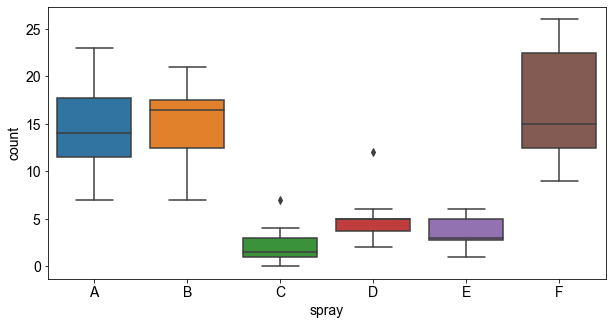

In [23]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.set_style('whitegrid')
seaborn.boxplot(x='spray', y='count', data=insect_sprays, ax=ax)
plt.show()

In [24]:
def testStat(a, b, groups):
    return np.mean([y for (x, y) in zip(a, b) if x == groups[0]]) \
        - np.mean([y for (x, y) in zip(a, b) if x == groups[1]])
    
groups = ['B', 'C']
subdata = insect_sprays[insect_sprays.spray.isin(groups)]

observedStat = testStat(subdata['spray'], subdata['count'], groups)

n = subdata['spray'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, subdata['count'], groups),
    [np.random.choice(subdata['spray'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

13.25
0.0


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


deviatia standard:  3.1312433631850976
quantila 2.5%: -6.076923076923077
quantila 97.5%: 6.076923076923077


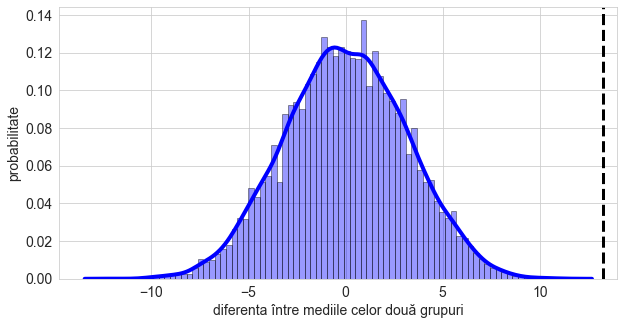

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()

In [26]:
groups = ['D', 'C']
subdata = insect_sprays[insect_sprays.spray.isin(groups)]

observedStat = testStat(subdata['spray'], subdata['count'], groups)

n = subdata['spray'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, subdata['count'], groups),
    [np.random.choice(subdata['spray'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

2.8333333333333335
0.0009


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


deviatia standard:  1.1010605607909658
quantila 2.5%: -2.0571428571428574
quantila 97.5%: 2.057142857142857


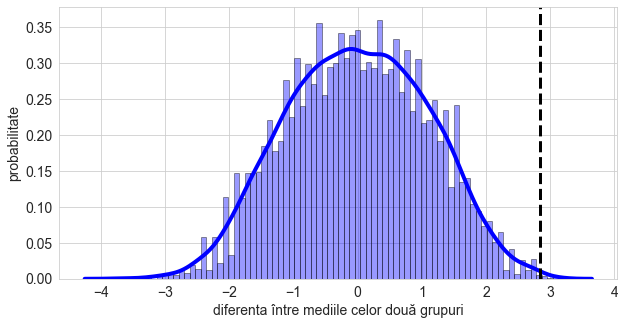

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()

# Laborator

__Q1__. Power este o probabilitate pentru care se presupune că este adevărată:

1. ipoteza nulă $H_0$
2. ipoteza alternativă $H_a$
3. ambele

In [28]:
# R. 2

__Q2__. Pe măsură ce dimensiunea sample-ului crește, restul menținîndu-se constant, ce se întâmplă cu power?

1. se mărește
2. se micșorează
3. rămâne la fel
4. nu putem preciza

In [29]:
# R. 1

__Q3__. Ce se întâmplă cu power pe măsură ce $\mu_a$ se îndepărtează față de $\mu_0$ ?

In [30]:
# R. Power crește

__Q4__. În contextul calculului power, ce este 'effect size'?

In [31]:
# R. Reprezintă diferența de medii in unități de deviație standard

__Q5__. Presupunem că în cazul unei testări A/B, o schemă de publicitate a determinat o medie de 10 achiziții pe zi pentru un sample de 100 de zile, în timp ce pentru cealaltă a determinat o medie de 11 achiziții pe zi, pentru același interval de 100 de zile. Presupunem o deviație standard de 4 achiziții pe zi pentru ambele distribuții. 

Media de 10 achiziții/zi este $\mu_0$ asociată ipotezei nule, iar pentru ipoteza alternativă $\mu_a = 11$. Care ar fi power pentru un test Z one-sided cu confidența de 95% ($\alpha=5\%$), în care presupunem că media achizițiilor a crescut la ipoteza alternativă?

In [36]:
import statsmodels.stats.power as smp
import scipy.stats as stats

mu0 = 10
mua = 11
sigma = 4
n = 100
alpha = 0.05

# Calculăm efectul (diferența între mediile ipotezei nule și ipotezei alternative, împărțită la deviația standard)
effect_size = (mua - mu0) / sigma

# Calculăm puterea testului Z one-sided
power = smp.normal_power(effect_size=effect_size, nobs=n, alpha=alpha, alternative='larger')
print('power:', power)


# Calculăm puterea testului direct
z_crit = stats.norm.ppf(1 - alpha)

# Calculăm puterea testului direct
power_direct = stats.norm.sf(z_crit - effect_size * (n**0.5))
print('power calculat direct:', power_direct)

power: 0.8037649400154937
power calculat direct: 0.803764940015494


__Q6__. Se dorește crearea unui studiu pentru detectarea valorii medii pe 4 ani a pierderii de volum a creierului de 0.01 $mm^3$. Presupunem că deviația standard pe media acestor 4 ani este de 0.04 $mm^3$. Care este numărul de voluntari pe care trebuie să se facă studiul pentru un test 5% vs. ipoteza nulă că nu se pierde deloc volum, pentru a atinge power de 80% ?

In [37]:
import statsmodels.stats.power as smp
import numpy as np

diff_mean = 0.01
sigma = 0.04
power = 0.8
alpha = 0.05
years = 4


# Calculăm numărul de voluntari necesari
n_volunteers     = statsmodels.stats.power.tt_solve_power(effect_size=diff_mean / sigma, power=power, alpha=alpha, alternative='larger')
print("Numărul de voluntari necesari:", round(n_volunteers))


Numărul de voluntari necesari: 100


__Q7__. Un studiu a observat asocierea mai multor factor nutriționali cu cancerul mamar (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4166692/). Au fost calculate următoarele p-values:

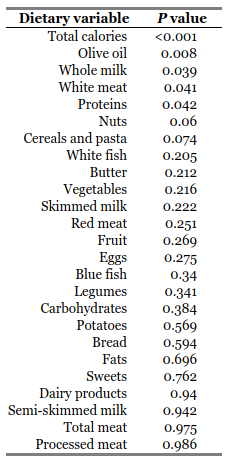

Considerăm un test cu 95% confidență.

a) Fără corecție, care factori sunt relevanți statistic ?

b) Aplicați corecția Bonferroni pe aceste p-values. Care din factori este statistic semnificativ.

c) Aplicați corecția Benjamini/Hochberg. Care factori sunt relevanți statistic?

Reprezentați grafic p-values cu corecția Bonferroni vs. p-values fără corecție, respectiv p-values cu corecția Benjamini/Hochberg vs. p-values fără corecție. Puneți pe ambele grafice și pragul de 0.05 ca să vedem ce rejectăm și ce nu.

In [38]:
# a) fara corectie
factors = pd.DataFrame({'variable': ['total calories', 'olive oil', 'whole meat', 'white meat', 'proteins', 
    'nuts', 'cereals and pasta', 'white fish', 'butter', 'vegetables', 'skimmed milk', 'red meat', 'fruit', 
    'eggs', 'blue fish', 'legumes', 'carbohydrates', 'potatoes', 'bread', 'fats', 'sweets', 'dairy', 
    'semi-skimmed', 'total meat', 'processed meat'], 
    'pvalue': [0.001, 0.008, 0.039, 0.041, 0.042, 0.06, 0.074, 0.205, 0.212, 0.216, 0.222, 0.251, 0.269, 0.275,
               0.34, 0.341, 0.384, 0.569, 0.594, 0.696, 0.752, 0.94, 0.942, 0.975, 0.986]})


alpha = 0.05

# Selectăm factorii relevanți statistic
relevant_factors = factors[factors['pvalue'] < alpha]

print("Factori relevanți statistic:")
print(relevant_factors)

Factori relevanți statistic:
         variable  pvalue
0  total calories   0.001
1       olive oil   0.008
2      whole meat   0.039
3      white meat   0.041
4        proteins   0.042


In [39]:
# b) corectia Bonferroni
alpha = 0.05
number_of_tests = len(factors)

# Aplicăm corecția Bonferroni
bonferroni_alpha = alpha / number_of_tests

# Selectăm factorii relevanți statistic după corecția Bonferroni
relevant_factors_bonferroni = factors[factors['pvalue'] < bonferroni_alpha]

print("Factori relevanți statistic după corecția Bonferroni:")
print(relevant_factors_bonferroni)

Factori relevanți statistic după corecția Bonferroni:
         variable  pvalue
0  total calories   0.001


In [40]:
alpha = 0.05
number_of_tests = len(factors)

# Ordonăm factorii în ordine crescătoare a p-value-urilor
factors_sorted = factors.sort_values(by='pvalue')

# Aplicăm corecția Benjamini/Hochberg
for i, row in factors_sorted.iterrows():
    if row['pvalue'] <= (i + 1) / number_of_tests * alpha:
        relevant_threshold = row['pvalue']
    else:
        break

# Selectăm factorii relevanți statistic după corecția Benjamini/Hochberg
relevant_factors_bh = factors[factors['pvalue'] <= relevant_threshold]

print("Factori relevanți statistic după corecția Benjamini/Hochberg:")
print(relevant_factors_bh)


Factori relevanți statistic după corecția Benjamini/Hochberg:
         variable  pvalue
0  total calories   0.001


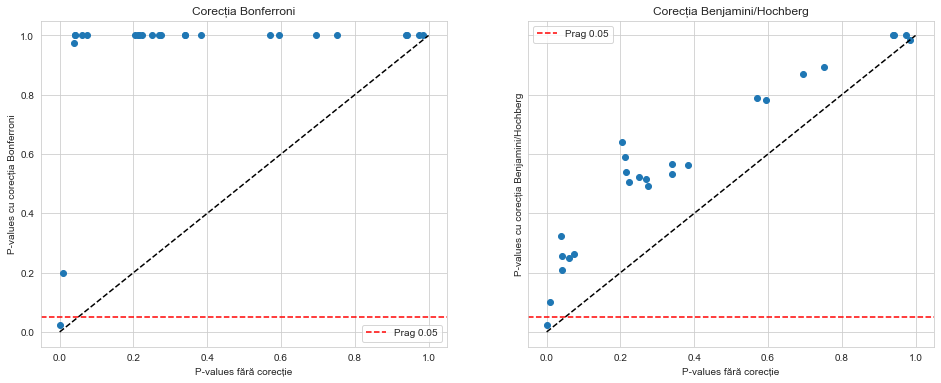

In [41]:
%matplotlib inline


# your compared graphs here

# Corecția Bonferroni
bonferroni_pvalues = factors['pvalue'] * number_of_tests
bonferroni_pvalues[bonferroni_pvalues > 1] = 1

# Corecția Benjamini/Hochberg
bh_pvalues = factors['pvalue'].copy()
bh_pvalues_sorted = np.sort(bh_pvalues)
bh_pvalues_sorted_adj = bh_pvalues_sorted *  number_of_tests / (np.arange(1,  number_of_tests + 1))
bh_pvalues_sorted_adj[bh_pvalues_sorted_adj > 1] = 1

for i, pvalue in enumerate(np.sort(factors['pvalue'])):
    bh_pvalues[factors['pvalue'] == pvalue] = bh_pvalues_sorted_adj[i]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Scatter plot pentru corecția Bonferroni
ax1.scatter(factors['pvalue'], bonferroni_pvalues)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.axhline(0.05, color='r', linestyle='--', label='Prag 0.05')
ax1.set_xlabel('P-values fără corecție')
ax1.set_ylabel('P-values cu corecția Bonferroni')
ax1.legend()
ax1.set_title('Corecția Bonferroni')

# Scatter plot pentru corecția Benjamini/Hochberg
ax2.scatter(factors['pvalue'], bh_pvalues)
ax2.plot([0, 1], [0, 1], 'k--')
ax2.axhline(0.05, color='r', linestyle='--', label='Prag 0.05')
ax2.set_xlabel('P-values fără corecție')
ax2.set_ylabel('P-values cu corecția Benjamini/Hochberg')
ax2.legend()
ax2.set_title('Corecția Benjamini/Hochberg')

plt.show()


__Q8__. Ce folosește procedura bootstrap pentru a estima distribuția sampled a unei statistici ?

In [42]:
# R. Procedura folosește resampling, extrăgând repetat noi eșantioane din eșantionul original.


__Q9__. Ce fac testele de resampling? Care este ipoteza nulă și care este ipoteza alternativă? Care este p-value?

In [43]:
# Testele de resampling implică extragerea de noi eșantioane de aceeași dimensiune din eșantionul inițial, cu înlocuire.
# Ipoteza nulă afirmă că distribuțiile observațiilor din fiecare grup sunt identice (provine din aceeași distribuție).
# Ipoteza alternativă susține că distribuțiile observațiilor din grupuri sunt diferite.
# P-value este o măsură a probabilității de a obține o statistică extremă cel puțin la fel de extremă ca cea observată, presupunând că 
# ipoteza nulă este adevărată

__Q10__. Realizați două grupuri de numere eșantionate din două distribuții, de medii 10 și respectiv 15, și dispersie 2. Etichetați fiecare sample cu numele grupului, A sau B. Grupurile au dimensiunile 40 și respectiv 50.

Ridicați whiskers plots pentru ambele grupuri.

a) Realizați testul de permutare pentru a arăta dacă numerele sunt sau nu extrase din aceeași distribuție. Stabiliți care este ipoteza nulă și care este ipoteza alternativă. Afișați distribuția mediei resample-urilor. Ce p-value obțineți pentru statistica de tip medie? Care este rezultatul testului ipotezei?

b) Creșteți dispersia grupurilor de la 2 la 100 și reluați experimentul. Ce constatați?

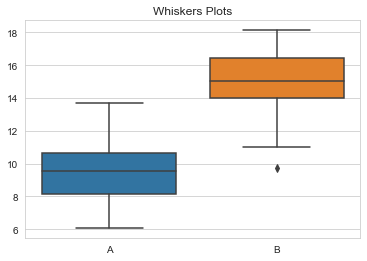

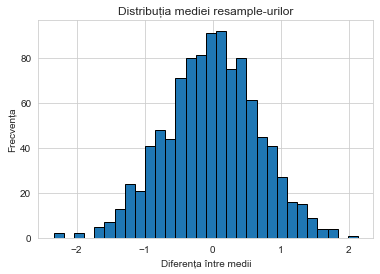

p-value: 0.0
Rezultatul testului ipotezei: Respingem ipoteza nulă. Grupurile provin din distribuții diferite.
p-value pentru dispersie crescută: 0.439
Rezultatul testului ipotezei (dispersie crescută): Nu putem respinge ipoteza nulă. Grupurile pot proveni din aceeași distribuție.


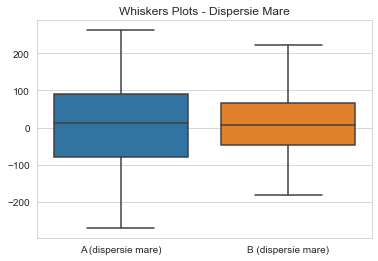

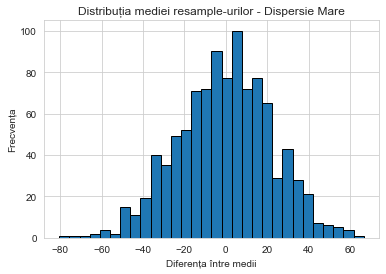

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Setarea seed-ului pentru reproducibilitate
np.random.seed(42)

# Crearea grupurilor A și B
group_A = np.random.normal(loc=10, scale=2, size=40)
group_B = np.random.normal(loc=15, scale=2, size=50)

# Afișarea whiskers plots
sns.boxplot(data=[group_A, group_B])
plt.xticks([0, 1], ["A", "B"])
plt.title("Whiskers Plots")
plt.show()

# a) Testul de permutare
def permutation_test(a, b, num_permutations=1000):
    combined = np.concatenate((a, b))
    actual_difference = np.abs(np.mean(a) - np.mean(b))
    count = 0
    permuted_mean_diff = []
    
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        perm_a, perm_b = combined[:len(a)], combined[len(a):]
        permuted_mean_diff.append(np.mean(perm_a) - np.mean(perm_b))
        if np.abs(np.mean(perm_a) - np.mean(perm_b)) >= actual_difference:
            count += 1
    
    p_value = count / num_permutations
    return p_value, permuted_mean_diff

# Ipoteza nulă: Grupurile A și B provin din aceeași distribuție
# Ipoteza alternativă: Grupurile A și B provin din distribuții diferite
p_value, permuted_mean_diff = permutation_test(group_A, group_B)

# Afișarea distribuției mediei resample-urilor
plt.hist(permuted_mean_diff, bins=30, edgecolor='black')
plt.title("Distribuția mediei resample-urilor")
plt.xlabel("Diferența între medii")
plt.ylabel("Frecvența")
plt.show()

print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Rezultatul testului ipotezei: Respingem ipoteza nulă. Grupurile provin din distribuții diferite.")
else:
    print("Rezultatul testului ipotezei: Nu putem respinge ipoteza nulă. Grupurile pot proveni din aceeași distribuție.")
    
    
# b) Creșterea dispersiei grupurilor și reluarea experimentului
group_A_large_variance = np.random.normal(loc=10, scale=100, size=40)
group_B_large_variance = np.random.normal(loc=15, scale=100, size=50)

p_value_large_variance, _ = permutation_test(group_A_large_variance, group_B_large_variance)
print(f"p-value pentru dispersie crescută: {p_value_large_variance}")

if p_value_large_variance < 0.05:
    print("Rezultatul testului ipotezei (dispersie crescută): Respingem ipoteza nulă. Grupurile provin din distribuții diferite.")
else:
    print("Rezultatul testului ipotezei (dispersie crescută): Nu putem respinge ipoteza nulă. Grupurile pot proveni din aceeași distribuție.")
    
# Afișarea whiskers plots pentru grupurile cu dispersie crescută
sns.boxplot(data=[group_A_large_variance, group_B_large_variance])
plt.xticks([0, 1], ["A (dispersie mare)", "B (dispersie mare)"])
plt.title("Whiskers Plots - Dispersie Mare")
plt.show()

# Testul de permutare pentru grupurile cu dispersie crescută
_, permuted_mean_diff_large_variance = permutation_test(group_A_large_variance, group_B_large_variance)

# Afișarea distribuției mediei resample-urilor pentru grupurile cu dispersie crescută
plt.hist(permuted_mean_diff_large_variance, bins=30, edgecolor='black')
plt.title("Distribuția mediei resample-urilor - Dispersie Mare")
plt.xlabel("Diferența între medii")
plt.ylabel("Frecvența")
plt.show()


In [45]:
# Comparand cele 2 sample-uri, observăm că diferența mediilor crește